In [7]:
import cv2
import numpy as np
import os
import random
import time
from mtcnn import MTCNN
from deepface import DeepFace
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import Counter


In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [1]:
dataset_path = "dataset_emociones" 
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

NameError: name 'os' is not defined

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)


val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 41367 images belonging to 5 classes.
Found 11817 images belonging to 5 classes.
Found 5915 images belonging to 5 classes.


In [38]:
num_classes = len(train_generator.class_indices)

# Modelo
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,589 (1.36 MB)

 Trainable params: 355,589 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [40]:
epochs = 150

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[es]
)


Epoch 1/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 465s 358ms/step - accuracy: 0.3777 - loss: 1.4593 - val_accuracy: 0.4944 - val_loss: 1.2257
Epoch 2/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 87s 67ms/step - accuracy: 0.4953 - loss: 1.2302 - val_accuracy: 0.5639 - val_loss: 1.0731
Epoch 3/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.5395 - loss: 1.1408 - val_accuracy: 0.5886 - val_loss: 1.0104
Epoch 4/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.5612 - loss: 1.0949 - val_accuracy: 0.5936 - val_loss: 1.0120
Epoch 5/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.5744 - loss: 1.0621 - val_accuracy: 0.6063 - val_loss: 0.9852
Epoch 6/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 87s 67ms/step - accuracy: 0.5874 - loss: 1.0289 - val_accuracy: 0.6302 - val_loss: 0.9232
Epoch 7/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 87s 68ms/step - accuracy: 0.5950 - loss: 1.0187 - val_accuracy: 0.6286 - val_loss: 0.9262
Epoch 8/150
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - accuracy

In [41]:
model.save("modelo_emociones.h5")

In [ ]:
# --- 1. Recreación del Generador de Prueba ---
dataset_path = "dataset_emociones"
test_dir = os.path.join(dataset_path, "test")


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False 
)

# --- 2. Carga del Modelo ---
try:
    loaded_model = load_model("modelo_emociones.h5")
    print("\nModelo cargado exitosamente: modelo_emociones.h5")
except:
    print("\n[ERROR] No se pudo cargar el modelo. Asegúrate de que el archivo 'modelo_emociones.h5' existe y la ruta es correcta.")
    exit()

Found 5915 images belonging to 5 classes.



Modelo cargado exitosamente: modelo_emociones.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

## 📋 Reporte de Clasificación en el Conjunto de Prueba ##
              precision    recall  f1-score   support

       Angry       0.56      0.67      0.61      1016
        Fear       0.55      0.36      0.44       974
       Happy       0.88      0.87      0.87      1845
         Sad       0.59      0.65      0.62      1256
    Surprise       0.74      0.77      0.76       824

    accuracy                           0.69      5915
   macro avg       0.66      0.66      0.66      5915
weighted avg       0.69      0.69      0.69      5915


## 🖼️ Matriz de Confusión (Sin normalizar) ##
Matriz de confusión sin Normalizar


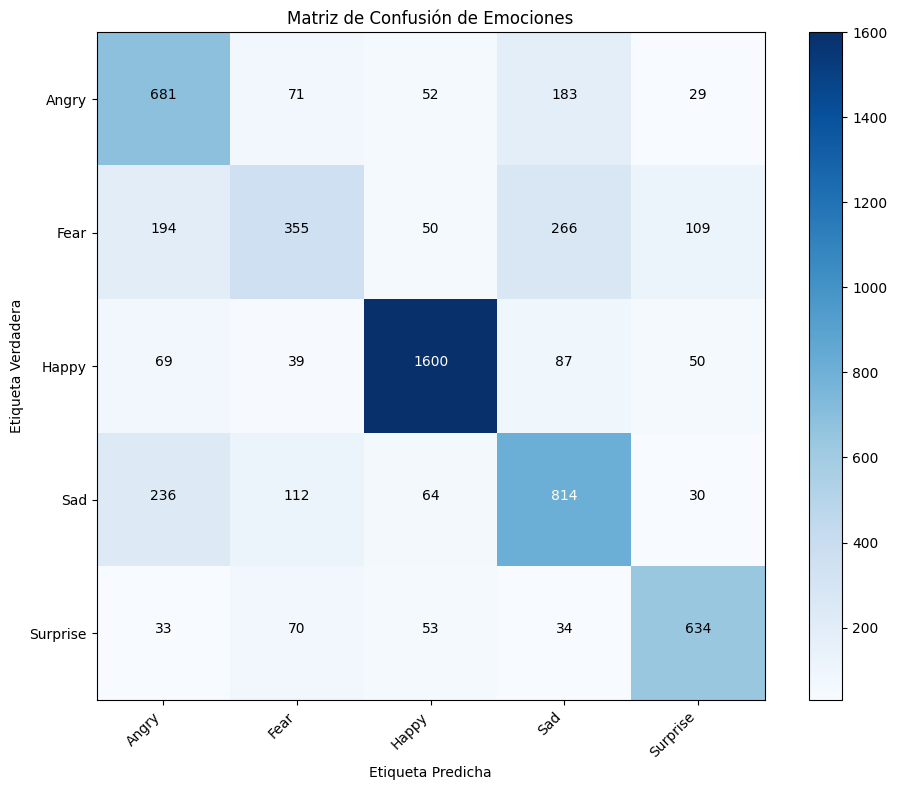


## 🖼️ Matriz de Confusión (Normalizada) ##
Matriz de confusión Normalizada


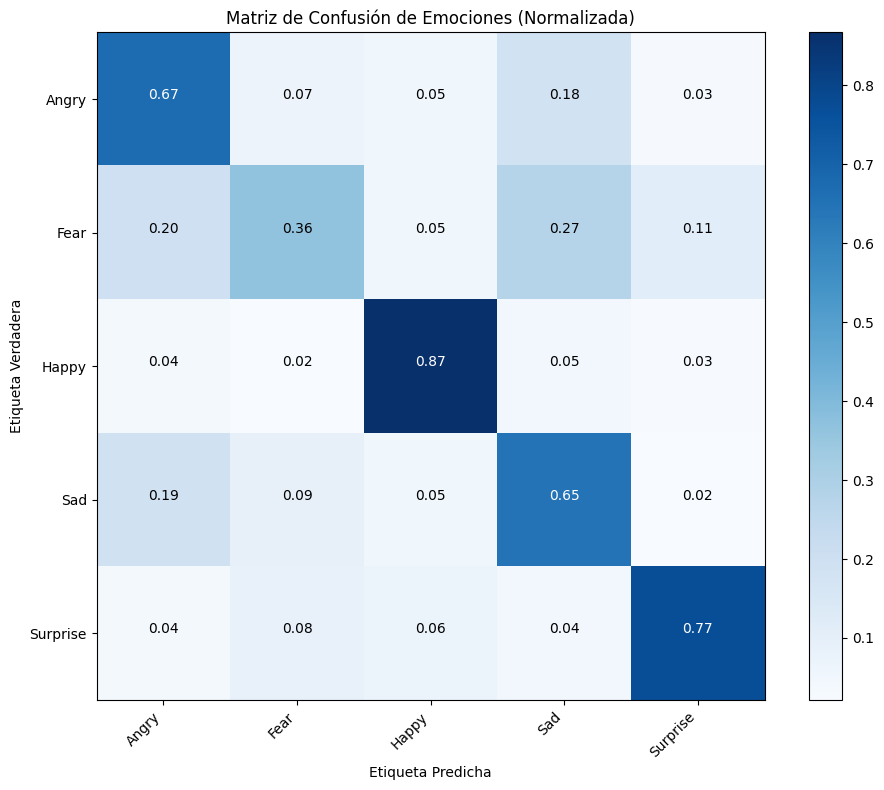

In [ ]:
# --- 3. Generar Predicciones ---
Y_pred = loaded_model.predict(test_generator)


y_pred_classes = np.argmax(Y_pred, axis=1)


y_true = test_generator.classes


class_names = list(test_generator.class_indices.keys())



print("\n" + "="*50)
print("## 📋 Reporte de Clasificación en el Conjunto de Prueba ##")
print("="*50)
print(classification_report(y_true, y_pred_classes, target_names=class_names))



cm = confusion_matrix(y_true, y_pred_classes)



def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    """
    Función que imprime y plotea la matriz de confusión.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        print("Matriz de confusión Normalizada")
    else:
        fmt = 'd'
        print('Matriz de confusión sin Normalizar')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.show()



print("\n" + "="*50)
print("## 🖼️ Matriz de Confusión (Sin normalizar) ##")
print("="*50)
plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusión de Emociones', normalize=False)

print("\n" + "="*50)
print("## 🖼️ Matriz de Confusión (Normalizada) ##")
print("="*50)
plot_confusion_matrix(cm, classes=class_names, title='Matriz de Confusión de Emociones (Normalizada)', normalize=True)

In [42]:
model_emotions = load_model("modelo_emociones.h5")


# Lista de clases del modelo de emociones
emotion_classes = ['Angry','Fear','Happy','Sad','Surprise']


In [62]:

# ----------------- configuración -----------------
ASSETS_DIR = "assets"   
MODEL_PATH = "modelo_emociones.h5"


def load_png(path):
    if not os.path.exists(path):
        return None
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  
    if img is None:
        return None
    
    if img.shape[2] == 3:
        b,g,r = cv2.split(img)
        alpha = np.ones(b.shape, dtype=b.dtype) * 255
        img = cv2.merge([b,g,r,alpha])
    return img

def overlay_image_alpha(img, img_overlay, x, y, overlay_size=None):
    if img_overlay is None:
        return img
    overlay = img_overlay.copy()
    if overlay_size is not None:
        overlay = cv2.resize(overlay, overlay_size, interpolation=cv2.INTER_AREA)

    b,g,r,a = cv2.split(overlay)
    overlay_rgb = cv2.merge((b,g,r))
    mask = cv2.merge((a,a,a))

    h, w = overlay_rgb.shape[:2]
    if x < 0:
        overlay_rgb = overlay_rgb[:, -x:]
        mask = mask[:, -x:]
        w += x
        x = 0
    if y < 0:
        overlay_rgb = overlay_rgb[-y:, :]
        mask = mask[-y:, :]
        h += y
        y = 0

    
    if y + h > img.shape[0]:
        h = img.shape[0] - y
        overlay_rgb = overlay_rgb[:h]
        mask = mask[:h]
    if x + w > img.shape[1]:
        w = img.shape[1] - x
        overlay_rgb = overlay_rgb[:, :w]
        mask = mask[:, :w]

    if h <= 0 or w <= 0:
        return img

    roi = img[y:y+h, x:x+w]
    
    alpha = mask.astype(float) / 255.0
    overlay_rgb = overlay_rgb.astype(float)
    roi = roi.astype(float)

    blended = cv2.multiply(alpha, overlay_rgb) + cv2.multiply(1 - alpha, roi)
    img[y:y+h, x:x+w] = blended.astype(np.uint8)
    return img

# ----------------- cargar assets -----------------
aura_png = load_png(os.path.join(ASSETS_DIR, "aura.png"))
halo_png = load_png(os.path.join(ASSETS_DIR, "halo.png"))
eye_glow_png = load_png(os.path.join(ASSETS_DIR, "eyes.png"))
tear_png = load_png(os.path.join(ASSETS_DIR, "tears.png"))

# ----------------- cargar modelo y detector -----------------
detector = MTCNN()
model = load_model(MODEL_PATH)


class Particle:
    def __init__(self, x, y, vx, vy, life, color, size):
        self.x = x; self.y = y
        self.vx = vx; self.vy = vy
        self.life = life
        self.color = color
        self.size = size

    def update(self, dt=1.0):
        self.x += self.vx * dt
        self.y += self.vy * dt
        self.vy += 0.3 * dt  
        self.life -= dt

    def is_alive(self):
        return self.life > 0

particles = []


def update_and_draw_particles(frame):
    for p in particles[:]:
        p.update()
        if not p.is_alive():
            particles.remove(p)
            continue
        cv2.circle(frame, (int(p.x), int(p.y)), p.size, p.color, -1)


def preprocess_face_for_emotion(face_bgr):
    gray = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (48,48))
    gray = gray.astype("float32") / 255.0
    gray = np.expand_dims(gray, axis=(0,-1)) 
    return gray


def effect_happy(frame, x, y, w, h, keypoints):
    
    if halo_png is not None:
        halo_w = int(w * 1.1)
        halo_h = int(halo_w * halo_png.shape[0] / halo_png.shape[1])
        hx = x + w//2 - halo_w//2
        hy = y - int(h * 0.55)
        frame = overlay_image_alpha(frame, halo_png, hx, hy, (halo_w, halo_h))
    
    for _ in range(6):
        cx = x + random.randint(0, w)
        cy = y + random.randint(-h//2, h)
        cv2.circle(frame, (cx, cy), random.randint(2,5), (random.randint(200,255), random.randint(100,255), random.randint(50,255)), -1)
    
    overlay = frame.copy()
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (255, 240, 200), -1)
    cv2.addWeighted(overlay, 0.03, frame, 0.97, 0, frame)
    return frame

def effect_sad(frame, x, y, w, h, keypoints):
   
    left_eye = keypoints.get('left_eye')
    right_eye = keypoints.get('right_eye')

    if tear_png is not None and left_eye and right_eye:

        eye_center_x = (left_eye[0] + right_eye[0]) // 2

        tears_width = int(w * 1.3) 
        aspect = tear_png.shape[0] / tear_png.shape[1]
        tears_height = int(tears_width * aspect)

        top_left_x = eye_center_x - tears_width // 2
        top_left_y = int((left_eye[1] + right_eye[1]) / 2 + h * 1)

        frame = overlay_image_alpha(frame, tear_png, top_left_x, top_left_y, (tears_width, tears_height))

    else:
        ex = x + int(w * 0.3)
        ey = y + int(h * 0.55)
        for i in range(3):
            cv2.circle(frame, (ex, ey + i*12), 5+i, (220,180,255), -1)
        ex2 = x + int(w * 0.7)
        ey2 = y + int(h * 0.55)
        for i in range(3):
            cv2.circle(frame, (ex2, ey2 + i*12), 5+i, (220,180,255), -1)

    
    overlay = frame.copy()
    cv2.rectangle(overlay, (0,0), (frame.shape[1], frame.shape[0]), (20,20,40), -1)
    cv2.addWeighted(overlay, 0.18, frame, 0.82, 0, frame)

    return frame

def effect_surprise(frame, x, y, w, h, keypoints):
    overlay = frame.copy()
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (255,255,255), -1)
    cv2.addWeighted(overlay, 0.18, frame, 0.82, 0, frame)
    for i in range(8):
        sx = x + random.randint(-w//4, w + w//4)
        sy = y + random.randint(-h//4, h + h//4)
        cv2.circle(frame, (sx, sy), random.randint(1,3), (255,255,255), -1)
    return frame

def effect_neutral(frame, x, y, w, h, keypoints):
    face_roi = frame[y:y+h, x:x+w]
    if face_roi.size != 0:
        smooth = cv2.bilateralFilter(face_roi, d=9, sigmaColor=75, sigmaSpace=75)
        frame[y:y+h, x:x+w] = cv2.addWeighted(face_roi, 0.6, smooth, 0.4, 0)
    return frame

def effect_angry(frame, x, y, w, h, keypoints):
    
    if aura_png is not None:
        aura_w = int(w * 2.0)
        aura_h = int(aura_w * aura_png.shape[0] / aura_png.shape[1])
        ax = x + w//2 - aura_w//2
        ay = y - int(h * 0.65)
        frame = overlay_image_alpha(frame, aura_png, ax, ay, (aura_w, aura_h))
    else:
        
        overlay = frame.copy()
        cv2.circle(overlay, (x + w//2, y + h//2 - int(h*0.2)), int(w*0.9), (0,200,255), -1)
        cv2.addWeighted(overlay, 0.15, frame, 0.85, 0, frame)


    return frame

# ----------------- bucle principal webcam -----------------
cap = cv2.VideoCapture(0)
fps_last = time.time()
frame_count = 0

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
output_fps = 30
out = cv2.VideoWriter("demo_emociones.mp4", fourcc, output_fps,
                      (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)

    detections = detector.detect_faces(frame)

    for det in detections:
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        keypoints = det.get('keypoints', {})

        
        CONFIDENCE_THRESHOLD = 0.5

        try:
            face = frame[y:y+h, x:x+w]
            if face.size == 0:
                continue

            inp = preprocess_face_for_emotion(face)
            pred = model.predict(inp)[0]       
            max_index = np.argmax(pred)
            max_conf = pred[max_index]

            if max_conf >= CONFIDENCE_THRESHOLD:
                emo = emotion_classes[max_index]
            else:
                emo = "Neutral"

        except Exception as e:
            emo = "Neutral"

        
        if emo == "Happy":
            frame = effect_happy(frame, x, y, w, h, keypoints)
        elif emo == "Sad":
            frame = effect_sad(frame, x, y, w, h, keypoints)
        elif emo == "Suprise":
            frame = effect_surprise(frame, x, y, w, h, keypoints)
        elif emo == "neutral":
            frame = effect_neutral(frame, x, y, w, h, keypoints)
        elif emo == "Angry":
            frame = effect_angry(frame, x, y, w, h, keypoints)
        else:
            pass  

        
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255,255,255), 1)
        cv2.putText(frame, emo.upper(), (x, y-10), cv2.FONT_HERSHEY_DUPLEX, 0.7, (255,255,255), 2)


    
    update_and_draw_particles(frame)

    out.write(frame)

    frame_count += 1
    if time.time() - fps_last >= 1.0:
        fps = frame_count / (time.time() - fps_last)
        fps_last = time.time()
        frame_count = 0
    cv2.putText(frame, f"Detector de emociones", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 1)

    cv2.imshow("Detector de emociones", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
out.release() 
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import random


mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


mp_drawing = mp.solutions.drawing_utils


In [4]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Índices de landmarks para cada parte facial
LEFT_EYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
RIGHT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
MOUTH_OUTER = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 409, 270, 269, 267, 0, 37, 39, 40, 185]
NOSE = [168, 6, 197, 195, 5, 4, 1, 19, 94, 2]


def create_mask_from_landmarks(landmarks, indices, width, height, padding=5):
    points = np.array([(int(landmarks[i].x * width),
                        int(landmarks[i].y * height)) for i in indices])
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)
    kernel = np.ones((padding, padding), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    return mask


def get_bounding_box(landmarks, indices, width, height, padding=20):
    points = [(int(landmarks[i].x * width),
               int(landmarks[i].y * height)) for i in indices]
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    x_min = max(0, min(x_coords) - padding)
    x_max = min(width, max(x_coords) + padding)
    y_min = max(0, min(y_coords) - padding)
    y_max = min(height, max(y_coords) + padding)
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2
    return (center_x, center_y), (x_min, y_min, x_max, y_max)


def extract_face_part_with_mask(frame, landmarks, indices, padding=20):
    height, width = frame.shape[:2]
    mask = create_mask_from_landmarks(landmarks, indices, width, height, padding=3)
    center, (x_min, y_min, x_max, y_max) = get_bounding_box(landmarks, indices, width, height, padding)
    part_img = frame[y_min:y_max, x_min:x_max].copy()
    mask_crop = mask[y_min:y_max, x_min:x_max]
    result = np.zeros_like(part_img)
    result[mask_crop > 0] = part_img[mask_crop > 0]
    return result, center


def place_part_on_canvas(canvas, part_img, target_pos, angle=0, scale=1.0):
    if part_img is None or part_img.size == 0:
        return
    h, w = part_img.shape[:2]
    new_w = int(w * scale)
    new_h = int(h * scale)
    if new_w <= 0 or new_h <= 0:
        return
    scaled = cv2.resize(part_img, (new_w, new_h))
    center = (new_w // 2, new_h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(scaled, M, (new_w, new_h),
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(0, 0, 0))
    x = target_pos[0] - new_w // 2
    y = target_pos[1] - new_h // 2
    x = max(0, min(x, canvas.shape[1] - new_w))
    y = max(0, min(y, canvas.shape[0] - new_h))
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    roi = canvas[y:y+new_h, x:x+new_w]
    if roi.shape[0] == new_h and roi.shape[1] == new_w:
        roi_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        part_fg = cv2.bitwise_and(rotated, rotated, mask=mask)
        canvas[y:y+new_h, x:x+new_w] = cv2.add(roi_bg, part_fg)


# --- Filtros ---
def create_face_collage_filter2(frame, landmarks):
    height, width = frame.shape[:2]
    canvas = np.zeros((height, width, 3), dtype=np.uint8)
    left_eye_img, left_eye_center = extract_face_part_with_mask(frame, landmarks, LEFT_EYE, padding=15)
    right_eye_img, right_eye_center = extract_face_part_with_mask(frame, landmarks, RIGHT_EYE, padding=15)
    mouth_img, mouth_center = extract_face_part_with_mask(frame, landmarks, MOUTH_OUTER, padding=20)
    scale_factor = 1.8
    place_part_on_canvas(canvas, left_eye_img, left_eye_center, scale=scale_factor)
    place_part_on_canvas(canvas, right_eye_img, right_eye_center, scale=scale_factor)
    place_part_on_canvas(canvas, mouth_img, mouth_center, scale=scale_factor)
    return canvas


def create_face_collage_filter3(frame, landmarks):
    canvas = frame.copy()
    left_eye_img, left_eye_center = extract_face_part_with_mask(frame, landmarks, LEFT_EYE, padding=15)
    right_eye_img, right_eye_center = extract_face_part_with_mask(frame, landmarks, RIGHT_EYE, padding=15)
    mouth_img, mouth_center = extract_face_part_with_mask(frame, landmarks, MOUTH_OUTER, padding=20)
    scale_factor = 1.8
    place_part_on_canvas(canvas, left_eye_img, left_eye_center, scale=scale_factor)
    place_part_on_canvas(canvas, right_eye_img, right_eye_center, scale=scale_factor)
    place_part_on_canvas(canvas, mouth_img, mouth_center, scale=scale_factor)
    return canvas


# ------------------------------------------------
# CAPTURA DE VIDEO
# ------------------------------------------------
cap = cv2.VideoCapture(0)
current_filter = 2


fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = 30
width = int(cap.get(3))
height = int(cap.get(4))
out = cv2.VideoWriter("filtro_demo.mp4", fourcc, fps, (width, height))


print("Controles:")
print("'2' - Filtro 2: Solo ojos y boca agrandados")
print("'3' - Filtro 3: Ojos y boca grandes sobre cara normal")
print("'q' - Salir")


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark

        if current_filter == 2:
            collage = create_face_collage_filter2(frame, landmarks)
            filter_name = "Filtro 2: Ojos + Boca (Grande)"
        else:
            collage = create_face_collage_filter3(frame, landmarks)
            filter_name = "Filtro 3: Ojos + Boca (Sobre cara)"

        cv2.putText(collage, filter_name, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        cv2.imshow('Face Collage', collage)

        
        out.write(collage)

    else:
        cv2.imshow('Face Collage', frame)
        out.write(frame)   

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    elif key == ord('2'):
        current_filter = 2
    elif key == ord('3'):
        current_filter = 3


# ------------------------------------------------
# LIBERAR RECURSOS
# ------------------------------------------------
cap.release()
out.release()   
cv2.destroyAllWindows()
face_mesh.close()


Controles:
'2' - Filtro 2: Solo ojos y boca agrandados
'3' - Filtro 3: Ojos y boca grandes sobre cara normal
'q' - Salir
